In [9]:
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

**Exploring the datasets**

Genres dataset has 164 lines and 4 features.
Echonest dataset has 11440 lines and 8 features.
Tracks dataset has 99995 lines and 13 features.
Spectral dataset has 99995 lines and 21 features.
NA values in each column of genres dataset:
genre_parent_id    13
dtype: int64
NA values in each column of echonest dataset:
danceability     19
speechiness     150
valence          21
dtype: int64
NA values in each column of tracks dataset:
album_title           911
artist_latitude     59788
artist_longitude    59788
genre_top           55362
title                   1
dtype: int64
NA values in each column of spectral dataset:
Series([], dtype: int64)


/var/folders/8w/3lg80w9149zg21tlm57prt_00000gp/T/ipykernel_16595/4206925099.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=na_pct.values, y=na_pct.index, palette='viridis')
/var/folders/8w/3lg80w9149zg21tlm57prt_00000gp/T/ipykernel_16595/4206925099.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=na_pct.values, y=na_pct.index, palette='viridis')
/var/folders/8w/3lg80w9149zg21tlm57prt_00000gp/T/ipykernel_16595/4206925099.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=na_pct.values, y=na_pct.index, palette='viridis')


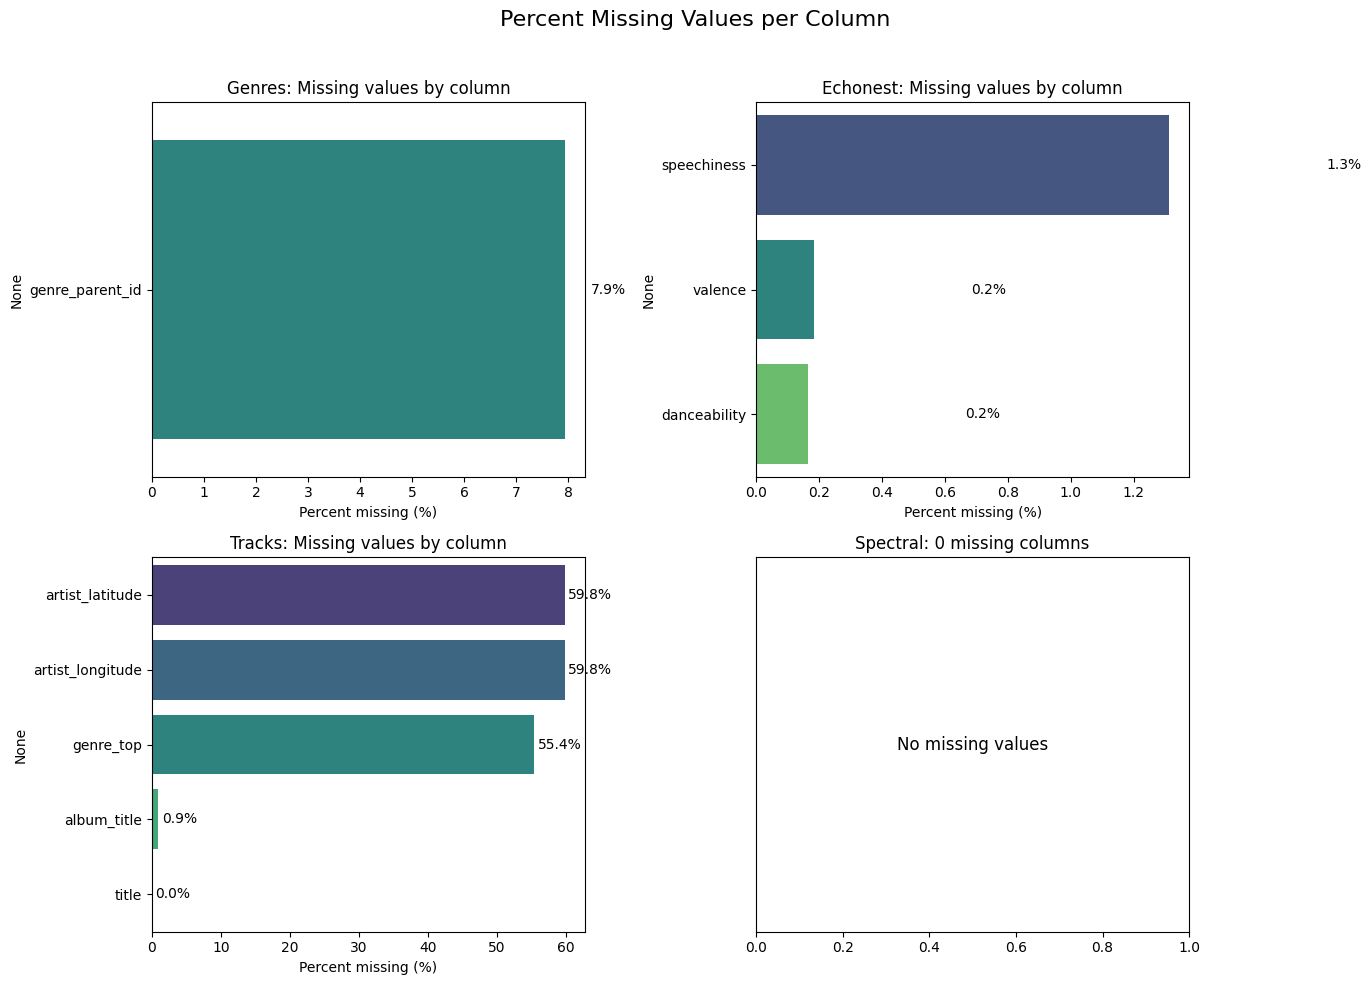

In [10]:
# Explore different datasets
# Load the genres dataset
genres_path = os.path.join('data', 'genres.csv')
genres = pd.read_csv(genres_path)

echonest_path = os.path.join('data', 'echonest_features.tsv')
echonest = pd.read_csv(echonest_path, sep='\t')

tracks_path = os.path.join('data', 'tracks.tsv')
tracks = pd.read_csv(tracks_path, sep='\t')

spectral_path = os.path.join('data', 'spectral_features.tsv')
spectral = pd.read_csv(spectral_path, sep='\t')

genres_n_features = genres.shape[1] - 1  # Exclude the label column
genres_n_lines = genres.shape[0]

print(f"Genres dataset has {genres_n_lines} lines and {genres_n_features} features.")

echonest_n_features = echonest.shape[1] - 1
echonest_n_lines = echonest.shape[0]

print(f"Echonest dataset has {echonest_n_lines} lines and {echonest_n_features} features.")

tracks_n_features = tracks.shape[1] - 1
tracks_n_lines = tracks.shape[0]

print(f"Tracks dataset has {tracks_n_lines} lines and {tracks_n_features} features.")

spectral_n_features = spectral.shape[1] - 1
spectral_n_lines = spectral.shape[0]

print(f"Spectral dataset has {spectral_n_lines} lines and {spectral_n_features} features.")


# Explore the NA values 
na_counts = genres.isna().sum()
print("NA values in each column of genres dataset:")
print(na_counts[na_counts > 0])

na_counts_echonest = echonest.isna().sum()
print("NA values in each column of echonest dataset:")
print(na_counts_echonest[na_counts_echonest > 0])

na_counts_tracks = tracks.isna().sum()
print("NA values in each column of tracks dataset:")
print(na_counts_tracks[na_counts_tracks > 0])       

na_counts_spectral = spectral.isna().sum()
print("NA values in each column of spectral dataset:")
print(na_counts_spectral[na_counts_spectral > 0])

# Clearer plots for missing values: percent missing per column
datasets = {'Genres': genres, 'Echonest': echonest, 'Tracks': tracks, 'Spectral': spectral}
plt.figure(figsize=(14, 10))
for i, (name, df) in enumerate(datasets.items(), 1):
    plt.subplot(2, 2, i)
    # percent of missing values by column (0-100)
    na_pct = df.isna().mean() * 100
    na_pct = na_pct[na_pct > 0].sort_values(ascending=False)
    if na_pct.empty:
        plt.text(0.5, 0.5, 'No missing values', ha='center', va='center', fontsize=12)
        plt.title(f'{name}: 0 missing columns')
        plt.xlabel('')
        plt.yticks([])
    else:
        sns.barplot(x=na_pct.values, y=na_pct.index, palette='viridis')
        plt.xlabel('Percent missing (%)')
        plt.title(f'{name}: Missing values by column')
        # annotate bars with percent values
        for j, v in enumerate(na_pct.values):
            plt.text(v + 0.5, j, f'{v:.1f}%', va='center')
plt.suptitle('Percent Missing Values per Column', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [11]:
# We re going to build a model to predict the genre_top
# The datset we re going to use is a merge of tracks['genre_top', genres, genre_all] and genres[genre_id,genre_handle,genre_parent_id,genre_title]
# We need to substitute the titles with ids in the genres dataset to be able to merge them

genres_id = genres[['genre_id', 'genre_parent_id', 'genre_title']]

# This is afunction that takes a colomn where features are titles and replace them with their corresponding ids from the genres_id

def replace_titles_with_ids(df, column, genres_id):
    title_to_id = dict(zip(genres_id['genre_title'], genres_id['genre_id']))
    df[column] = df[column].map(title_to_id)
    return df

# print(tracks['genre_top'])

replace_titles_with_ids(tracks, 'genre_top', genres_id)
# print(tracks)

# Turn the values in genre_top to int 
tracks['genre_top'] = tracks['genre_top'].astype('Int64')
# print(tracks['genre_top'].dtype)
# print(tracks)

# save the tracks_id dataset 
tracks.to_csv('data/tracks_id.tsv', sep='\t', index=False)


In [12]:
# Now we re going to construct a dataset where genres are titles and not numbers 
# We can use the genres_id dataset to map back the genre_top ids to titles

from collections.abc import Iterable
import ast

def replace_ids_with_titles(df, column, genres_id):
    id_to_title = dict(zip(genres_id['genre_id'], genres_id['genre_title']))
    df = df.copy()

    def map_ids(x):
        # treat iterables (lists, tuples, sets, etc.) as collections of ids
        if isinstance(x, Iterable) and not isinstance(x, (str, bytes)):
            return [id_to_title.get(i) for i in x]
        # treat scalars (single id) as one id
        return id_to_title.get(x, x)

    df[column] = df[column].apply(map_ids)
    return df

tracks['genres'] = tracks['genres'].apply(ast.literal_eval)
tracks['genres_all'] = tracks['genres_all'].apply(ast.literal_eval)


# print the type of the values in 'genres' column
print(tracks['genres'].apply(type).unique())
print(tracks['genres_all'].apply(type).unique())

tracks_titles = replace_ids_with_titles(tracks.copy(), 'genre_top', genres_id)
tracks_titles = replace_ids_with_titles(tracks_titles, 'genres', genres_id)
tracks_titles = replace_ids_with_titles(tracks_titles, 'genres_all', genres_id)

tracks_titles.to_csv('data/tracks_titles.tsv', sep='\t', index=False)


[<class 'list'>]
[<class 'list'>]


In [13]:
# test the function

# build the mapping, the parent should be a root node, see root_nodes
# We should keep going up the tree until we reach a root node
mapping_genre_parent = {}

parent_lookup = dict(zip(genres['genre_id'], genres['genre_parent_id']))

for gid in genres['genre_id']:
    current = gid
    parent = parent_lookup.get(current)

    while True:

        # Stop if parent is NaN
        if pd.isna(parent):
            break

        # Stop if parent points to itself (self-loop)
        if parent == current:
            break

        # Otherwise climb one level
        current = parent
        parent = parent_lookup.get(current)

    # current is now a root or self-parent
    mapping_genre_parent[gid] = current


# shape of unique values in mapping_genre_parent
print(len(set(mapping_genre_parent.values())))



14


In [14]:
# Define a function for filling the NA values of top genre using this strategy
# 1. if there is a dominant parent in genres, aka has more occurrences or more occurences of his sons, then we assign the parent as top genre
# 2. else we do the same to genres_all
# 3. else we choose randomly from the root genres in genres list
# if the parent is na in the mapping, then the parent is himself

def fill_top_genre(df, parent_genre_map):
    import random
    df = df.copy()

    # Identify root genres (parent = itself)
    root_genres = [gid for gid, root in parent_genre_map.items() if gid == root]

    for idx, row in df.iterrows():

        # Only fill missing values
        if pd.isna(row['genre_top']):

            # ----------------------------------------------------
            # STEP 1: Dominant parent in genres
            # ----------------------------------------------------
            genre_counts = {}
            if isinstance(row['genres'], list):
                for gid in row['genres']:
                    parent = parent_genre_map.get(gid)
                    if parent is not None:
                        genre_counts[parent] = genre_counts.get(parent, 0) + 1

            if genre_counts:
                df.at[idx, 'genre_top'] = max(genre_counts, key=genre_counts.get)
                continue

            # ----------------------------------------------------
            # STEP 2: Dominant parent in genres_all
            # ----------------------------------------------------
            genre_all_counts = {}
            if isinstance(row['genres_all'], list):
                for gid in row['genres_all']:
                    parent = parent_genre_map.get(gid)
                    if parent is not None:
                        genre_all_counts[parent] = genre_all_counts.get(parent, 0) + 1

            if genre_all_counts:
                df.at[idx, 'genre_top'] = max(genre_all_counts, key=genre_all_counts.get)
                continue

            # ----------------------------------------------------
            # STEP 3: Use first available genre (genres, then genres_all)
            # ----------------------------------------------------
            genres_list = row['genres'] if isinstance(row['genres'], list) else []
            genres_all_list = row['genres_all'] if isinstance(row['genres_all'], list) else []

            # If both empty: drop row
            if len(genres_list) == 0 and len(genres_all_list) == 0:
                df = df.drop(index=idx)
                continue

            # Else pick first valid gid
            if len(genres_list) > 0:
                first_gid = genres_list[0]
            else:
                first_gid = genres_all_list[0]

            root_parent = parent_genre_map.get(first_gid, first_gid)
            df.at[idx, 'genre_top'] = root_parent

    return df




In [15]:
# remove the 
tracks_filled = fill_top_genre(tracks, mapping_genre_parent)
print(tracks_filled['genre_top'].isna().sum())

# save the filled dataset
tracks_filled.to_csv('data/tracks_filled_me.tsv', sep='\t', index=False)

0
